

---

## I. Introduction to Chains and Context

Chains are a **very important component** of LangChain, so much so that the framework's name is based on this concept. Chains are essential for building complex applications using Large Language Models (LLMs).

### A. Progress Recap

Prior to discussing Chains, the LangChain playlist covered two other important components:
1.  **Models:** How to interact with different types of AI models.
2.  **Prompts:** How to send various types of inputs to LLMs.

Additionally, the process of generating **structured output** from LLMs, including the concept of **Output Parsers**, was discussed.

### B. Necessity of Chains

An LLM-based application is typically built from **multiple smaller steps**. A simple application involves three steps: requesting a prompt from the user, sending the prompt to the LLM, and processing and displaying the LLM's response to the user.

Executing all these steps individually is a very **manual process**. This approach requires manually designing prompts (e.g., using `PromptTemplate`), requesting user input (e.g., using the `invoke` function), manually calling the LLM (`llm.invoke`), and extracting the content from the output.

**Chains solve this problem by allowing developers to create a pipeline**:
*   Chains connect all the necessary steps (e.g., prompt design, input submission, output processing).
*   The **output of a preceding step automatically becomes the input for the next step** in the pipeline.
*   Once the pipeline is built and the initial input is provided to the first step, the chain executes automatically until the final output is produced. This significantly simplifies the workload.

### C. Types of Chains

Chains are flexible and can be used to build various structures. The three main types of chains demonstrated are:

1.  **Sequential (Linear) Chains:** Steps are connected in a series.
2.  **Parallel Chains:** Enables **parallel processing**, allowing multiple steps or chains to run simultaneously.
3.  **Conditional Chains:** Allows execution based on a specific condition, similar to an If-Else statement.

## II. Constructing Chains and Key Components

The syntax used to form chains by connecting components with the pipe operator (`|`) is called the **LangChain Expression Language (LCEL)**.

### A. Simple Sequential Chain Example

A basic sequential chain generating five facts about a topic was built using three components:

| Step | Component Class | Purpose |
| :--- | :--- | :--- |
| **1 (Prompt)** | `PromptTemplate` | Defines the input structure and variables (e.g., `topic`). |
| **2 (Model)** | `ChatOpenAI` | The LLM component that processes the prompt. |
| **3 (Parser)** | `StringOutputParser` | Ensures the output is returned as a simple string, removing metadata. |

**Chain Construction (LCEL Syntax):**
```
chain = prompt | model | parser
result = chain.invoke({"topic": "cricket"})
```
The application executes entirely through this single invocation, first receiving the topic, formatting the prompt, sending it to the model, and then parsing the output. The chain structure can be visualized using `chain.get_graph().print_ascii()`.

### B. Longer Sequential Chain Example

A more complex sequential application was created to generate a detailed report on a topic and then summarize that report into five key points (requiring two LLM calls).

1.  **Prompt 1:** Asks the model to "Generate a detailed report on {topic}".
2.  **Model/Parser 1:** Generates the report text.
3.  **Prompt 2:** Asks the model to "Generate a five pointer summary from the following {text}" (where the output of step 2 is the input text).
4.  **Model/Parser 2:** Generates the summary.

**Chain Construction:**
```
chain = prompt_one | model | parser | prompt_two | model | parser
```

### C. Parallel Chain Example

This example involved taking a detailed text document and running two processes simultaneously: generating notes and generating a quiz, followed by a merging step.

#### 1. Models and Prompts Used:
*   **Model 1:** `ChatOpenAI`.
*   **Model 2:** `ChatAnthropic` (or a similar alternative model).
*   **Prompt 1 (Notes):** "Generate short and simple notes from the following text".
*   **Prompt 2 (Quiz):** "Generate five short question answers from the following text".
*   **Prompt 3 (Merge):** "Merge the provided notes and quiz into a single document," expecting input variables `notes` and `quiz`.

#### 2. Parallel Mechanism: `RunnableParallel`
To run the Notes generation chain and the Quiz generation chain simultaneously, the concept of **`RunnableParallel`** is utilized. `RunnableParallel` is a type of *Runnable* that allows the parallel execution of multiple chains.

The parallel chains are defined in a dictionary, which links names (like 'notes' and 'quiz') to their respective linear chain structures:
```python
# The structure of the Parallel Chain creation
parallel_chain = RunnableParallel(
    notes=prompt_one | model_one | parser,
    quiz=prompt_two | model_two | parser
)
```
#### 3. Merging and Final Chain
The outputs of the `parallel_chain` (which are the notes and the quiz) are then sequentially fed into a `merge_chain`.

**Final Chain Construction:**
```python
final_chain = parallel_chain | merge_chain
```

### D. Conditional Chain Example

Conditional Chains allow implementing **If-Else logic** based on an LLM's output. The application built here classifies user feedback sentiment (Positive or Negative) and generates a reply corresponding to that sentiment.

#### 1. Ensuring Consistent Classification Output

Since the subsequent branching relies on the exact classification word (e.g., "Positive" or "Negative"), the output must be structured and consistent. This is achieved using the **Pydantic Output Parser**.

*   A Pydantic `BaseModel` called `Feedback` is defined, requiring the `sentiment` field to be a **`Literal`** (meaning its value can only be "Positive" or "Negative").
*   The `PydanticOutputParser` (`parser_two`) is used with the format instructions passed into the first prompt (`prompt_one`).
*   The initial classification chain is: `prompt_one | model | parser_two`. This guarantees the output is structured and reliable.

#### 2. Conditional Mechanism: `RunnableBranch`

The branching logic is implemented using **`RunnableBranch`**, which acts as the LangChain equivalent of an If-Else statement.

`RunnableBranch` accepts a series of tuples: `(condition, chain_to_execute)`.

**Branch Chain Logic:**
1.  **Condition 1 (Positive):** If the classification output (`x.sentiment`) is equal to "Positive," execute `Prompt 2` (Write a positive response).
2.  **Condition 2 (Negative):** If the classification output (`x.sentiment`) is equal to "Negative," execute `Prompt 3` (Write an appropriate response to this negative feedback).
3.  **Default/Fallback:** If neither condition is met, a **`RunnableLambda`** is executed. `RunnableLambda` converts a simple Python function (like a lambda function) into a Runnable object so it can be used as part of a chain. This serves as the `Else` case.

**Final Chain Construction:**
```python
final_chain = classification_chain | branch_chain
```

## III. Concepts for Further Exploration

The video sets up several concepts critical to understanding the underlying mechanics of chains, which will be covered in the subsequent video:

*   **Runnables:** The core concept that defines how chains work behind the scenes and how different components interact.
*   **LangChain Expression Language (LCEL):** The specifics and workings of the pipe operator syntax used to connect components.

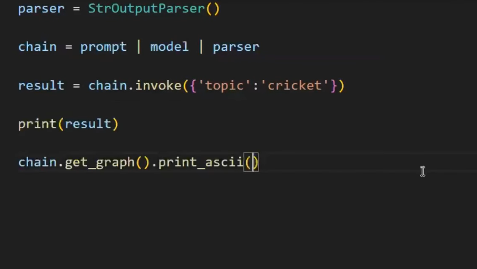

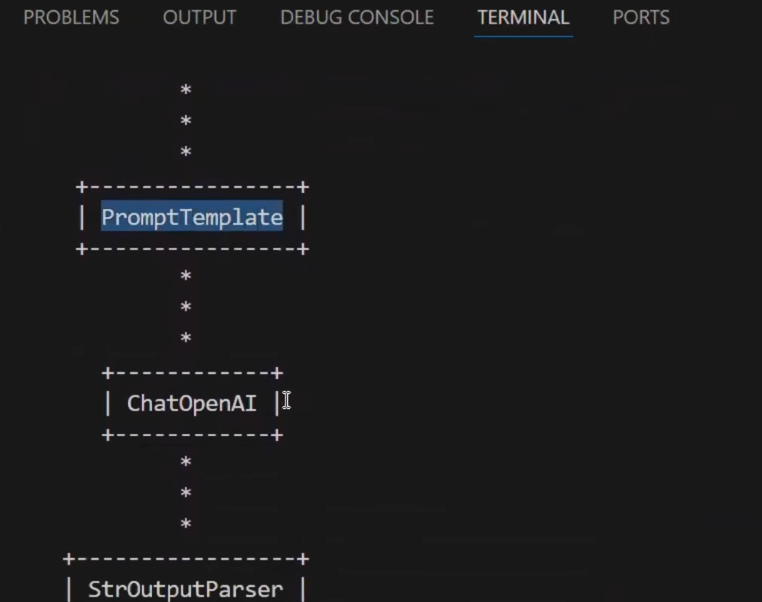

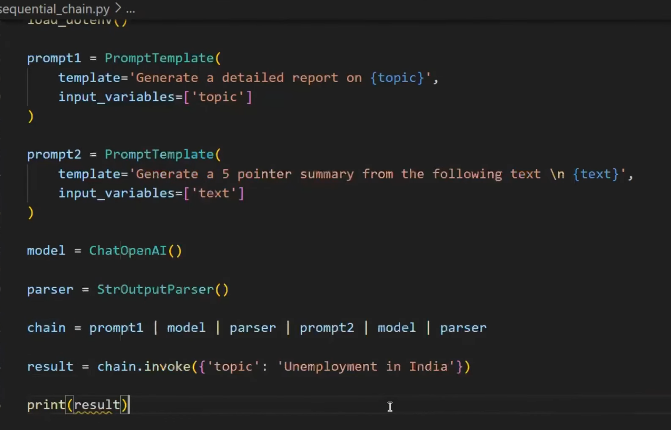

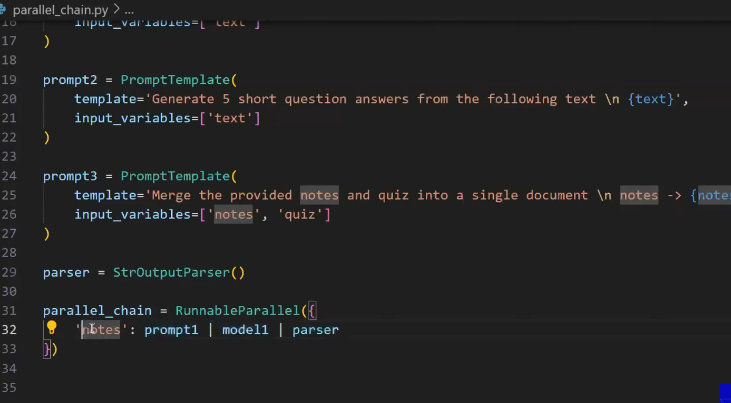

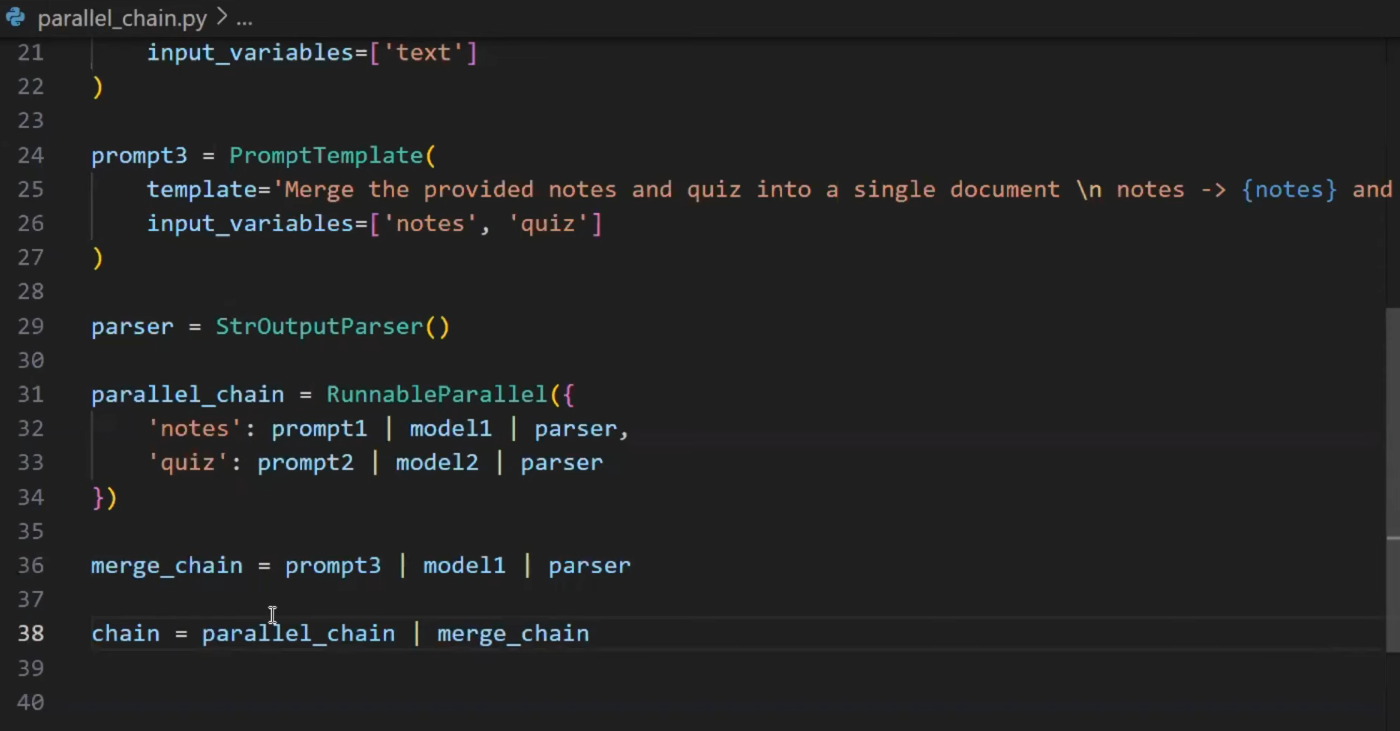

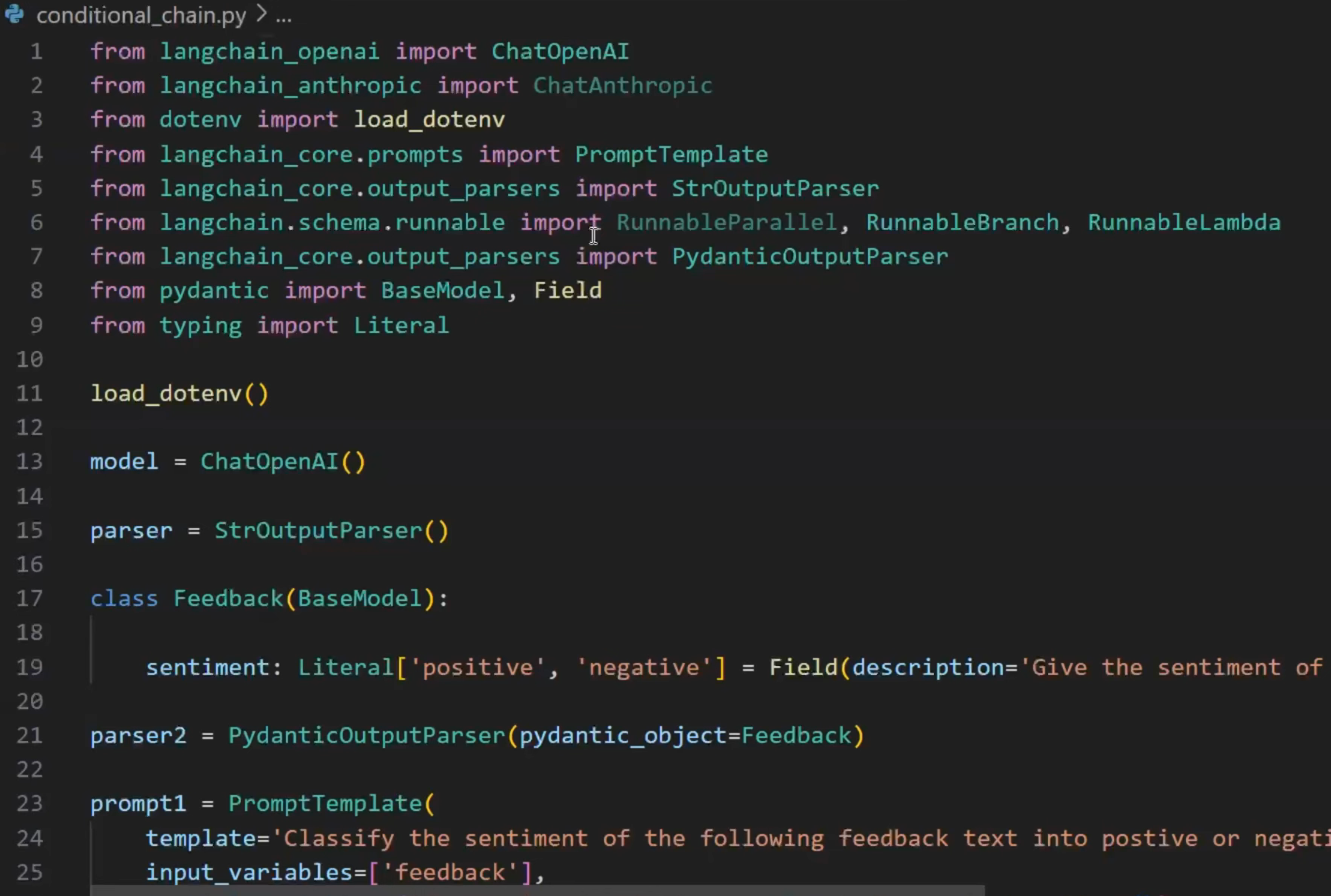

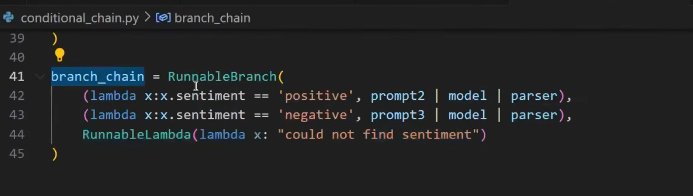



The three main types of complex chains covered are:

1.  **Sequential Chains:** These chains connect steps in a series (linearly) to execute a task, where the output of one step automatically becomes the input for the next step. This allows you to build a linear or sequential pipeline. The sources demonstrate two examples of sequential chains:
    *   A simple three-step chain involving a prompt, a model, and a parser.
    *   A longer sequential chain involving two separate calls to an LLM, such as generating a detailed report and then summarizing it in a five-point summary.
2.  **Parallel Chains:** These allow you to execute two or more chains simultaneously (in parallel). This is useful for processing an input document and generating multiple outputs, such as generating notes and a quiz simultaneously from the same text. The creation of parallel chains uses a component called `RunnableParallel`.
3.  **Conditional Chains:** These allow for branching logic, similar to an "If-Else" statement, where different chains are executed based on a specific condition. For example, classifying user feedback as positive or negative and then triggering a specialized response chain based on that classification. The creation of conditional chains uses a component called `RunnableBranch`.

These chains provide mechanisms to create complex applications by connecting components like models, prompts, and parsers into automated pipelines.

***

To clarify the function of these chain types:

If you view creating an LLM application as a factory production line, the **Sequential Chain** is like a standard assembly line where work passes from one station to the next in order. The **Parallel Chain** is like having two assembly lines running simultaneously from the same starting material to produce two different products. The **Conditional Chain** acts like a quality control checkpoint: depending on whether the product passes inspection (the condition), it is sent down one specialized line (positive feedback path) or another (negative feedback path).